# Quantify interaction between theta and low-gamma through distribution of P-episodes along theta phase

### P-episodes ref: Vass et al, 2016 Neuron. [from Ekstrom lab]. In our analysis we set the 
### power threshold as the 70th percentile and episode duration at 3 cycles of corresponding frequency

### Theta phase was computed by applying a band pass filter (2-8HZ) on the lfp signal, 
### Hilbert transform it, and extract the angular component of the envelope. 

In [1]:
## plot
%matplotlib inline
import matplotlib.pyplot as plt

## operations
import numpy as np
from scipy.io import loadmat
from scipy import signal
from scipy.signal import butter, lfilter, hilbert, chirp

from scipy import stats 

## time_frequency
from mne.time_frequency import tfr_array_multitaper, psd_array_multitaper
from mne.stats import permutation_cluster_1samp_test, permutation_cluster_test


## pac
# from pactools import Comodulogram, REFERENCES
# from pactools import simulate_pac

import pandas as pd

from statsmodels.formula.api import ols, mixedlm
import statsmodels.api as sm

## Saving data dictionaries
import pickle  

# Load study related info

In [2]:
## Load study related info
with open('../Results/study_info.pickle', 'rb') as handle:
    study_info = pickle.load(handle,encoding='latin1')
    

density        = study_info['density'] 
speed          = study_info['speed'] 
dd             = study_info['dd'] ## Number of sensory cues (density)
dur            = study_info['dur'] ## Trial duration (sec)
K_i_idx        = study_info['K_i_idx']
K_i            = study_info['K_i']
uni            = study_info['uni']
t_dur          = study_info['t_dur']
t_dd           = study_info['t_dd']
sessions       = study_info['sessions'] 
ttl_idx        = study_info['ttl_idx']
hpc_electrodes = study_info['hpc_electrodes']
fs = study_info['fs']



## Load trial markers for each session
with open('../Results/trials_markers.pickle', 'rb') as handle:
    trials_markers = pickle.load(handle,encoding='latin1')

# Util functions for signal processing

In [3]:
"""
This cell contains useful functions to analyse the data
"""

def bandPassFilter(s,fL,fH,b,fs):
    '''
    s = data  \n
    fL =  #low Cutoff frequency (in (0, 0.5)). \n
    fH =  #high Cutoff frequency (in (0, 0.5)). \n
    b = 0.08  # Transition band      (in (0, 0.5)). \n
    N = int(np.ceil((4 / b))) \n
    '''
    
    fL = fL/float(fs)
    fH = fH/float(fs)
    b  = b/float(fs)
    N = int(np.ceil((4 / b)))
    
    if not N % 2: N += 1  # Make sure that N is odd.
    n = np.arange(N)

    # Compute a low-pass filter with cutoff frequency fH.
    hlpf = np.sinc(2 * fH * (n - (N - 1) / 2.))
    hlpf *= np.blackman(N)
    hlpf = hlpf / np.sum(hlpf)

    # Compute a high-pass filter with cutoff frequency fL.
    hhpf = np.sinc(2 * fL * (n - (N - 1) / 2.))
    hhpf *= np.blackman(N)
    hhpf = hhpf / np.sum(hhpf)
    hhpf = -hhpf
    hhpf[ ((N - 1) / 2).astype(int) ] += 1

    # Convolve both filters.
    h = np.convolve(hlpf, hhpf)
    mar = (len(h)-1)/2
    return np.convolve(s,h)


def bandpass_filter_conv( data, low_freq, high_freq, fs ):

    fL =  float(low_freq) / fs
    fH =  float(high_freq) / fs

    b = 0.08
    N = int(np.ceil((4 / b)))
    if not N % 2: N += 1  # Make sure that N is odd.
    n = np.arange(N)

    # low-pass filter
    hlpf = np.sinc(2 * fH * (n - (N - 1) / 2.))
    hlpf *= np.blackman(N)
    hlpf = hlpf / np.sum(hlpf)

    # high-pass filter 
    hhpf = np.sinc(2 * fL * (n - (N - 1) / 2.))
    hhpf *= np.blackman(N)
    hhpf = hhpf / np.sum(hhpf)
    hhpf = -hhpf
    hhpf[int((N - 1) / 2)] += 1

    h = np.convolve(hlpf, hhpf)
    new_signal = np.convolve(data, h)
    
    return new_signal


def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y


def smooth_signal(p, sz=40, sigma=10):
    '''
        sz :  length of gaussFilter vector
        sigma = 10     
    '''    
    x = np.linspace(-sz / 2, sz / 2, sz);
    gaussFilter = np.exp(-x** 2 / (2 * sigma**2));
    gaussFilter = gaussFilter / sum (gaussFilter); # normalize
    pp = np.convolve(p, gaussFilter, 'same');    
    return pp

# Compute P_episodes in low gamma (25-49Hz) and their relation with theta (2-8Hz) phase

### Be aware: it takes a dozen of minutes to compute the following cell

In [4]:
### Log P-episodes phase for all sessions
p_epi_all = []
p_epi_all_phase = []


### Run each session
for sub in range(len(sessions)):

    ### Load this session dataset
    lfp = loadmat('../Data/'+sessions[sub]+'.mat')
    lfp = lfp['ourData']
    
    
    ### index of all trials start in this session
    idx_trials = trials_markers[sessions[sub]]

    ### temp list of P-episodes for this session
    p_epi_sub = []
    p_epi_sub_phase = []

    
    ### Loop through this session/patient hippocampal channel
    for cc in hpc_electrodes[sub]:
        
        ### Get this channel LFP 
        tmp_lfp = lfp[cc] 

        ### get power
        freqs = np.logspace(*np.log10([1, 49]), num=60) # define frequencies of interest (log-spaced)
        n_cycles = freqs / 2.  # different number of cycle per frequency
        power = tfr_array_multitaper(  [[ tmp_lfp ]] , fs, freqs=freqs, output='power' ) # extract power spectrogram
        power = power[0,0]
        power_zs = stats.zscore(power)  # Zscore spectrogram 
        
        
        #### theta band passed signal
        lfp_band_pass =  bandpass_filter_conv( tmp_lfp, 2, 8, fs ) # butter_bandpass_filter( tmp_lfp, 1, 8, fs, order=4)

        
        ### List of episodes in this channel
        tmp_p_episodes = []

        ### Frequencies of interest: 25-49Hz. l_f and h_f are their index in the spectrogram
        l_f = np.abs(freqs - 25.).argmin()
        h_f = np.abs(freqs - 49.).argmin()

        Dt_n_cycles = 3  ### P-episode duration criteria
        
        
        
        ### For logging purposes
        p_epi_contact = []
        p_epi_contact_phase = []
        
        ### Loop through each frequency of interest
        for fff in range(l_f, h_f):

            ### Set threshold of power activity in the zscored power of each frequency
            thresh = np.percentile(power_zs[fff],70)  

            ### a binnary vector to include detected moments where power was above thresh 
            p_epi = np.zeros_like( power_zs[fff] )
            p_epi[ power_zs[fff] > thresh ] = 1

            ### Duration of P-episode criteria for this frequency
            Dt_duration = fs/ freqs[fff] * Dt_n_cycles

            ### First derivative of the moments where high power is met will allow us to check for duration criteria
            p_epi_diff = np.diff(p_epi)

            p_epi_diff_u = np.where(p_epi_diff==1)[0]
            p_epi_diff_d = np.where(p_epi_diff==-1)[0]

            if p_epi_diff_d.size != p_epi_diff_u.size:
                if p_epi_diff_u[0] - p_epi_diff_d[0] < 0:  p_epi_diff_u = p_epi_diff_u[:-1]
                else:  p_epi_diff_d = p_epi_diff_d[:-1]


            idx_p_epi = np.where( np.abs(p_epi_diff_u - p_epi_diff_d) >= Dt_duration )[0]
            idx_p_epi = p_epi_diff_u[idx_p_epi]
            

            p_epi_trial = []   ## count number of p_episodes in each trial
            p_epi_trial_phase = []   ## count number of p_episodes in each trial
            
            ### Here we already got the P-episodes throught the experiment. 
            ### Now, lets look at the ones in each trial and save the theta phase where they occur
            for tt in trials_markers[sessions[sub]]:
                
                
                ### Get the Hilbert of this LFP band passed and extract its phase
                analytic_signal = hilbert(lfp_band_pass[tt:tt+int(fs*8.)])
                phase = np.angle(analytic_signal)

                ### Find P-episodes in this trial
                ss = np.where(  np.logical_and( idx_p_epi > tt , idx_p_epi < tt+ fs*8. ))[0]
                ss_size = ss.size
                
                
                p_epi_trial.append( ss )
                
                ### Save the theta phase of each P-episode 
                if ss_size>0 :
                    p_epi_trial_phase.append( phase[ss] )
                else: p_epi_trial_phase.append( [] )
                
                
            p_epi_contact.append( p_epi_trial )
            p_epi_contact_phase.append(p_epi_trial_phase)
            
        p_epi_sub.append( p_epi_contact )
        p_epi_sub_phase.append( p_epi_contact_phase )
        
    p_epi_all.append( p_epi_sub )
    p_epi_all_phase.append(p_epi_sub_phase)


# Distribution of number of P_episodes per theta phase
### All trials

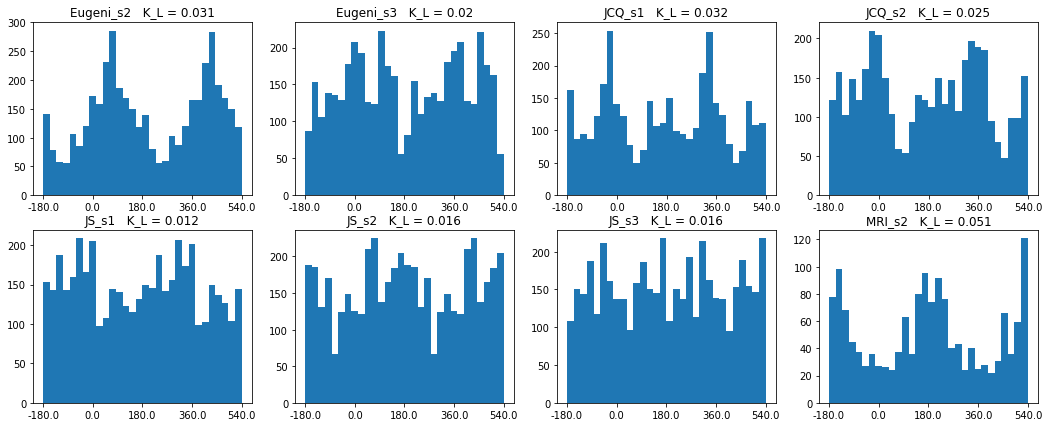

In [125]:
### Compute PAC for all trials together

### Data list (array) containing phase of P-episodes (p_epi_all_phase) has the following structure:
### Subject -> hippocampal channel (contact) -> frequency -> trial -> list of P-episodes theta phase (if they exist)

plt.figure(figsize=(18,7))
for sub in range(len(p_epi_all_phase)):

    phaaa = []

    for contact in range( len(p_epi_all_phase[sub])):
        for frequency in range(len(p_epi_all_phase[sub][contact])):
            for trial in range(len(p_epi_all_phase[sub][contact][frequency])):
                for kk in p_epi_all_phase[sub][contact][frequency][trial]:
                    phaaa.append(kk)

    phaaa = np.array(phaaa)
    phaaa_2 = np.hstack((phaaa , phaaa+np.radians(360)))
    
    
    num_bins = 30
    pha_hist = np.histogram(phaaa, bins=int(num_bins))
    phase_dist = pha_hist[0]
    n_pevents = float(np.sum(phase_dist))
    ppp = -1 * np.sum((phase_dist/n_pevents) * np.log((phase_dist/n_pevents)))
    K_L = (np.log(num_bins) - ppp) / np.log(num_bins)
    
    plt.subplot(2,4,sub+1)
    plt.title(  sessions[sub] + '   K_L = ' + str(np.round(K_L,3)))
    plt.hist(phaaa_2,bins=num_bins, color='k');
    plt.xticks( np.arange(-np.pi, 4*np.pi, np.pi) , np.rad2deg(np.arange(-np.pi, 4*np.pi, np.pi))  )


# plt.savefig('../Figures/ppec_all.pdf')

# Distribution of number of P_episodes per theta phase

## Speed trial type

In [153]:
K_L_all = [] 
for sub in range(len(p_epi_all_phase)):
    
    K_L_sub = []
    
    for ss in range(3):
        
        log_phases_at_speed = []
                
        ### Do you remember the speed and density variables?? We gonna use them now to split trials    
        ### Here looking for the 3 condition of SPEED
        trial_indx = np.where(speed==ss)[0]
        
        for trial in trial_indx:

            for contact in range(len(p_epi_all_phase[sub])):

                for freq in range(len(p_epi_all_phase[sub][contact])):

                    log_phases_at_speed.append( p_epi_all_phase[sub][contact][freq][trial] )
                    
        
        phaaa = np.concatenate(log_phases_at_speed)
        num_bins = 20
        pha_hist = np.histogram(phaaa, bins=int(num_bins))
        phase_dist = pha_hist[0]
        n_pevents = float(np.sum(phase_dist))
        
        ## There are some phases with no P-episodes, which leads to division by zero error. 
        ## To avoid that, I'll add one (fictional) event at each phase bin. 
        phase_dist += 1  
        
        ppp = -1 * np.sum((phase_dist/n_pevents) * np.log((phase_dist/n_pevents)))
        K_L = (np.log(num_bins) - ppp) / np.log(num_bins)
        
        if np.isnan(K_L): print( sub, ss, len(phaaa))

        K_L_sub.append(K_L)
        
    K_L_all.append(K_L_sub)

Text(0.5, 1.0, 'pval = 0.11')

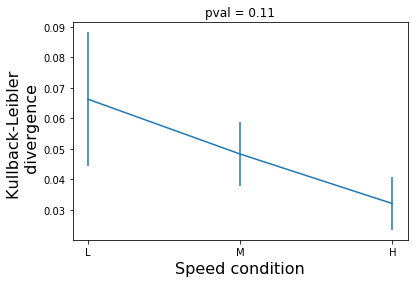

In [154]:
K_L_all = np.array(K_L_all)

mmm_speed = np.mean(K_L_all,0)
sss_speed = stats.sem(K_L_all,0)

plt.errorbar( range(mmm_speed.size), mmm_speed, yerr=sss_speed )

plt.xticks(  [0,1,2], ['L','M','H'])

plt.xlabel('Speed condition', fontsize=16)
plt.ylabel('Kullback-Leibler \n divergence', fontsize=16)

pval_speed = stats.pearsonr(np.tile(np.arange(3),K_L_all.shape[0]) , K_L_all.reshape(K_L_all.size))[1]
pval_speed = np.round(pval_speed,3)
plt.title('pval = ' + str(pval_speed))

## Density trial type

In [155]:
K_L_all = [] 
for sub in range(len(p_epi_all_phase)):
    
    K_L_sub = []
    
    for ss in range(3):
        
        log_phases_at_speed = []
    
        ### Do you remember the speed and density variables?? We gonna use them now to split trials    
        ### Here looking for the 3 condition of DENSITY
        trial_indx = np.where(density==ss)[0]
        
        for trial in trial_indx:

            for contact in range(len(p_epi_all_phase[sub])):

                for freq in range(len(p_epi_all_phase[sub][contact])):

                    log_phases_at_speed.append( p_epi_all_phase[sub][contact][freq][trial] )
                    
        
        phaaa = np.concatenate(log_phases_at_speed)
        num_bins = 20
        pha_hist = np.histogram(phaaa, bins=int(num_bins))
        phase_dist = pha_hist[0]
        n_pevents = float(np.sum(phase_dist))
        
        ## There are some phases with no P-episodes, which leads to division by zero error. 
        ## To avoid that, I'll add one (fictional) event at each phase bin. 
        phase_dist += 1  

        ppp = -1 * np.sum((phase_dist/n_pevents) * np.log((phase_dist/n_pevents)))
        K_L = (np.log(num_bins) - ppp) / np.log(num_bins)
        
        if np.isnan(K_L): print( sub, ss, len(phaaa) )

        K_L_sub.append(K_L)
        
    K_L_all.append(K_L_sub)

Text(0.5, 1.0, 'pval = 0.945')

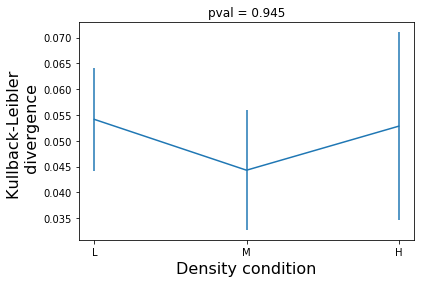

In [156]:
K_L_all = np.array(K_L_all)

mmm_density = np.mean(K_L_all,0)
sss_density = stats.sem(K_L_all,0 )

plt.errorbar( range(mmm_density.size), mmm_density, yerr=sss_density )

plt.xticks(  [0,1,2], ['L','M','H'])

plt.xlabel('Density condition', fontsize=16)
plt.ylabel('Kullback-Leibler \n divergence', fontsize=16)

pval_density = stats.pearsonr(np.tile(np.arange(3),K_L_all.shape[0]) , K_L_all.reshape(K_L_all.size))[1]
pval_density = np.round(pval_density,3)
plt.title('pval = ' + str(pval_density))

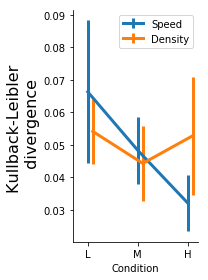

In [157]:
fig = plt.figure()
ax = fig.add_subplot(111)

fig.set_figheight(4)
fig.set_figwidth(3)


ax.errorbar( range(mmm_speed.size), mmm_speed, yerr=sss_speed, label='Speed',linewidth=3  )
ax.errorbar( np.arange(mmm_density.size)+0.1, mmm_density, yerr=sss_density, label='Density',linewidth=3  )

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


plt.sca(ax)
plt.xticks( range(3) , ['L','M','H'] )
plt.legend( frameon=False, loc='upper left')

plt.ylabel('Kullback-Leibler \n divergence', fontsize=16)
plt.xlabel('Condition')

plt.legend(loc='best')
plt.xlim(-.3)
plt.tight_layout()


# plt.savefig('../Figures/coupling_speed_and_density.pdf')

## Cues/sec trial type

In [158]:
K_L_all = [] 
for sub in range(len(p_epi_all_phase)):


    pac_by_K_info = [ [] for ii in range(uni.size)  ]

    for ttt in range(uni.size):

        kkk = np.where(  K_i == uni[ttt] )

        hh = np.where( np.logical_and(  speed   == kkk[0],  density == kkk[1]  ) )

        for trial in hh:
            
            for this_trial in trial:
            
                for contact in range(len(p_epi_all_phase[sub])):

                        for freq in range(len(p_epi_all_phase[sub][contact])):

                            log_phases_at_speed.append( p_epi_all_phase[sub][contact][freq][this_trial] )

            phaaa = np.concatenate(log_phases_at_speed)
            num_bins = 40
            pha_hist = np.histogram(phaaa, bins=int(num_bins))
            phase_dist = pha_hist[0]
            n_pevents = float(np.sum(phase_dist))
            phase_dist += 1

            ppp = -1 * np.sum((phase_dist/n_pevents) * np.log((phase_dist/n_pevents)))
            K_L = (np.log(num_bins) - ppp) / np.log(num_bins)

            
            pac_by_K_info[ttt] = K_L

    K_L_all.append(pac_by_K_info)
    
    
K_L_all = np.array(K_L_all)

No handles with labels found to put in legend.


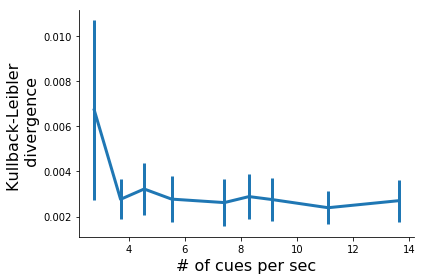

In [159]:
fig = plt.figure()
ax = fig.add_subplot(111)

fig.set_figheight(4)
fig.set_figwidth(6)


mmm = np.mean(K_L_all,0)
sss = stats.sem(K_L_all,0) 


plt.errorbar( uni, mmm, yerr=sss, linewidth=3 )


idx_mod = np.repeat(uni, K_L_all.shape[0]).reshape(  K_L_all.shape[0], K_L_all.shape[1] )
x = np.ravel(idx_mod)
y = np.ravel(K_L_all)
pval = stats.pearsonr(x,y)

# plt.title('Pval ' + str(pval))
    
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.sca(ax)
plt.legend( frameon=False, loc='upper left')

plt.xlabel('# of cues per sec', fontsize=16)
plt.ylabel('Kullback-Leibler \n divergence', fontsize=16)

plt.tight_layout()
# plt.savefig('../Figures/p_epi_divergence_n_cues_sec.pdf')


# This experiment is composed by Speed and Density variables.
#### Each variable modulates the amount of sensory information per time window at which the patient is exposed to.
#### We gonna combine these two variables in a single dimension: Number of local cues per second

### Speed affected the duration of each lap (trial)

#### Speed

\begin{array}{rr} \hline
Speed condition &low &medium &high  \\ \hline
Duration (sec) &18.1 &13.5 &11 \\ \hline
\end{array}


#### Density

\begin{array}{rr} \hline
Density condition &low &medium &high  \\ \hline
Local cues in lap (number) &50 &100 &150 \\ \hline
\end{array}




In [160]:
K_L_all = [] 
for sub in range(len(p_epi_all_phase)):


    pac_by_K_info = [ [] for ii in range(uni.size)  ]

    for ttt in range(uni.size):

        kkk = np.where(  K_i == uni[ttt] )    

        hh = np.where( np.logical_and(  speed   == kkk[0],  density == kkk[1]  ) )

        
        for trial in hh:
            
            for this_trial in trial:
            
                for contact in range(len(p_epi_all_phase[sub])):

                        for freq in range(len(p_epi_all_phase[sub][contact])):

                            log_phases_at_speed.append( p_epi_all_phase[sub][contact][freq][this_trial] )

            phaaa = np.concatenate(log_phases_at_speed)
            num_bins = 40
            pha_hist = np.histogram(phaaa, bins=int(num_bins))
            phase_dist = pha_hist[0]
            n_pevents = float(np.sum(phase_dist))
            phase_dist += 1

            ppp = -1 * np.sum((phase_dist/n_pevents) * np.log((phase_dist/n_pevents)))
            K_L = (np.log(num_bins) - ppp) / np.log(num_bins)

            
            pac_by_K_info[ttt] = K_L

    K_L_all.append(pac_by_K_info)
    
    
K_L_all = np.array(K_L_all)

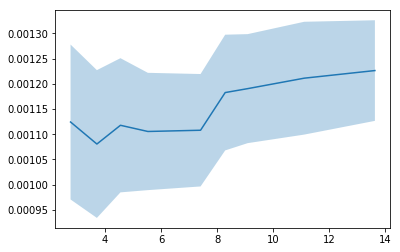

In [161]:
mm1 = np.mean(K_L_all,axis=0)
ss1 = stats.sem(K_L_all,axis=0)

# plt.errorbar(  uni, mm1, yerr=ss1 )


plt.fill_between( uni, mm1-ss1, mm1+ss1, alpha=0.3  )
plt.plot( uni, mm1 )

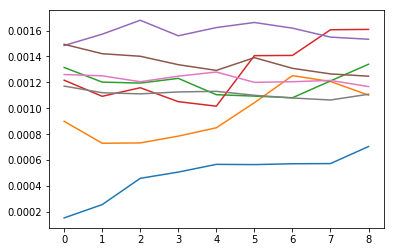

In [135]:
plt.plot(  K_L_all.T )